## 1. Import Libraries


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# For feature selection
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# For models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# For warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Explore the Dataset


In [4]:
# Load the dataset
# Assuming the dataset is in the same directory as this notebook
df = pd.read_csv("alzheimers_prediction_dataset.csv")

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (74283, 25)


,Country,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,...,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
0,Spain,90,Male,1,33.0,Medium,Never,Occasionally,No,No,...,Healthy,High,Retired,Single,No,Low,Medium,High,Urban,No
1,Argentina,72,Male,7,29.9,Medium,Former,Never,No,No,...,Healthy,Medium,Unemployed,Widowed,No,High,Low,High,Urban,No
2,South Africa,86,Female,19,22.9,High,Current,Occasionally,No,Yes,...,Average,Medium,Employed,Single,No,Low,Medium,High,Rural,No
3,China,53,Male,17,31.2,Low,Never,Regularly,Yes,No,...,Healthy,Medium,Retired,Single,No,High,Medium,Low,Rural,No
4,Sweden,58,Female,3,30.0,High,Former,Never,Yes,No,...,Unhealthy,High,Employed,Married,No,Low,Medium,High,Rural,No


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

Missing values per column:
Series([], dtype: int64)


Target variable distribution:
Alzheimer’s Diagnosis
No     43570
Yes    30713
Name: count, dtype: int64
Percentage of positive cases: 41.35%


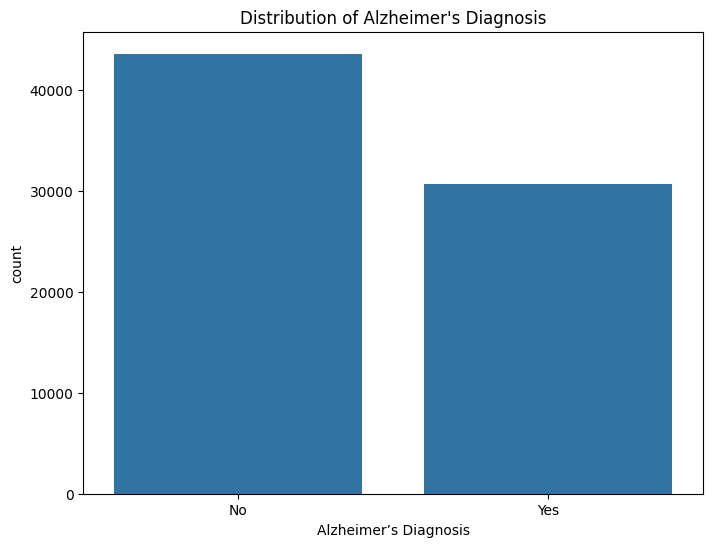

In [6]:
# Check the distribution of the target variable
target_counts = df["Alzheimer’s Diagnosis"].value_counts()
print("Target variable distribution:")
print(target_counts)
print(f"Percentage of positive cases: {target_counts['Yes']/len(df)*100:.2f}%")

# Visualize the target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="Alzheimer’s Diagnosis", data=df)
plt.title("Distribution of Alzheimer's Diagnosis")
plt.show()

In [7]:
# Separate the majority and minority classes
df_majority = df[df['Alzheimer’s Diagnosis'] == "No"]
df_minority = df[df['Alzheimer’s Diagnosis'] == "Yes"]

# Downsample the majority class
df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

# Combine the downsampled majority class with the minority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the distribution of the target variable
print("Balanced target variable distribution:")
print(df_balanced['Alzheimer’s Diagnosis'].value_counts())

Balanced target variable distribution:
Alzheimer’s Diagnosis
No     30713
Yes    30713
Name: count, dtype: int64


In [8]:
df = df_balanced.copy()

## 3. Data Preprocessing and Feature Engineering


In [9]:
# Check data types
df.dtypes

Country                                  object
Age                                       int64
Gender                                   object
Education Level                           int64
BMI                                     float64
Physical Activity Level                  object
Smoking Status                           object
Alcohol Consumption                      object
Diabetes                                 object
Hypertension                             object
Cholesterol Level                        object
Family History of Alzheimer’s            object
Cognitive Test Score                      int64
Depression Level                         object
Sleep Quality                            object
Dietary Habits                           object
Air Pollution Exposure                   object
Employment Status                        object
Marital Status                           object
Genetic Risk Factor (APOE-ε4 allele)     object
Social Engagement Level                 

In [10]:
'Education Level','BMI','Cognitive Test Score'

('Education Level', 'BMI', 'Cognitive Test Score')

In [11]:
# Convert target variable to binary (0/1)
df['Alzheimer’s Diagnosis'] = df['Alzheimer’s Diagnosis'].map({'No': 0, 'Yes': 1})

# Separate features and target
X = df.drop(['Alzheimer’s Diagnosis'], axis=1)
y = df['Alzheimer’s Diagnosis']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

Categorical columns: 20
Numerical columns: 4


In [12]:
df.head()

,Country,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,...,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
0,Canada,75,Male,1,23.4,High,Never,Occasionally,No,No,...,Unhealthy,Low,Unemployed,Single,No,Medium,High,High,Urban,0
1,UK,68,Male,18,29.4,Low,Former,Regularly,No,Yes,...,Unhealthy,Low,Employed,Widowed,No,Medium,Low,High,Rural,0
2,India,51,Female,9,24.7,Low,Former,Occasionally,No,No,...,Average,High,Unemployed,Widowed,No,High,High,Low,Rural,0
3,Germany,91,Female,3,34.5,Medium,Former,Occasionally,No,No,...,Unhealthy,Low,Unemployed,Widowed,No,High,Low,Low,Rural,0
4,Australia,91,Male,7,20.9,High,Current,Occasionally,No,Yes,...,Average,Medium,Retired,Single,No,Medium,Medium,Low,Rural,0


In [16]:
from sklearn.preprocessing import LabelEncoder

# Encode each categorical column using LabelEncoder and concatenate the results

encoded_data = pd.DataFrame()
for col in categorical_cols:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(X[col])

encoded_feature_names = encoded_data.columns.tolist()
encoded_df = encoded_data

# Display the first few rows of the encoded DataFrame
encoded_df.head()

,Country,Gender,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,Cholesterol Level,Family History of Alzheimer’s,Depression Level,Sleep Quality,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living
0,3,1,0,2,1,0,0,0,0,2,0,2,1,2,1,0,2,0,0,1
1,18,1,1,1,2,0,1,1,0,2,1,2,1,0,2,0,2,1,0,0
2,7,0,1,1,1,0,0,1,0,2,2,0,0,2,2,0,0,0,1,0
3,6,0,2,1,1,0,0,1,0,1,1,2,1,2,2,0,0,1,1,0
4,1,1,0,0,1,0,1,1,1,2,1,0,2,1,1,0,2,2,1,0


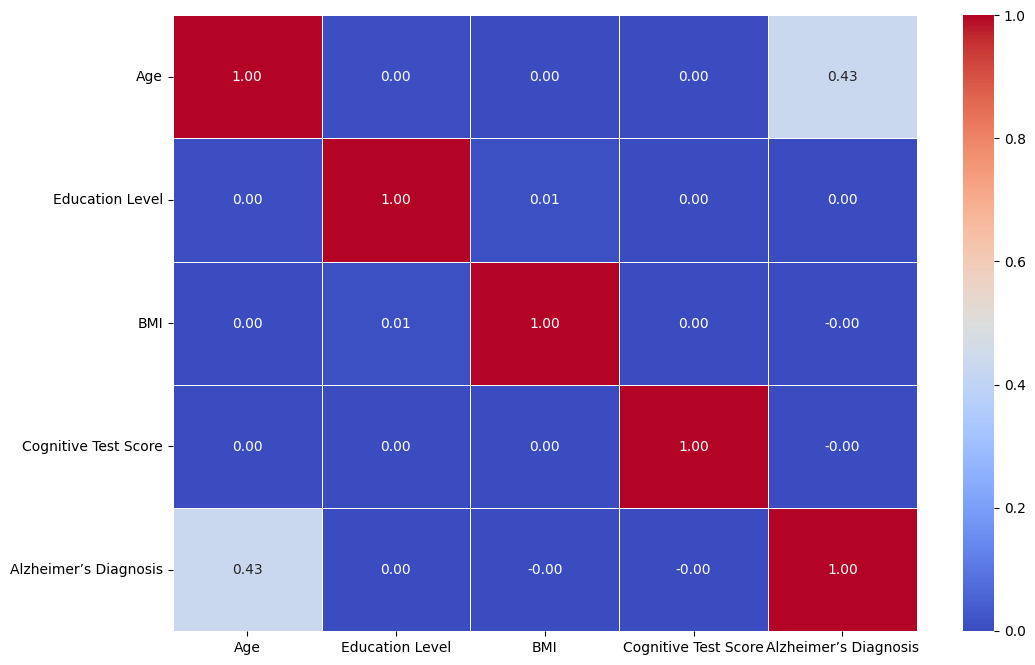

In [110]:
correlation_matrix = df[numerical_cols+['Alzheimer’s Diagnosis']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True,cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

In [17]:
correlation_matrix = encoded_df.join(df[numerical_cols]).join(df[['Alzheimer’s Diagnosis']]).corr().style.background_gradient(cmap='coolwarm')
correlation_matrix

,Country,Gender,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,Cholesterol Level,Family History of Alzheimer’s,Depression Level,Sleep Quality,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Age,Education Level,BMI,Cognitive Test Score,Alzheimer’s Diagnosis
Country,1.000000,-0.008319,-0.002131,0.000360,0.000882,-0.000395,-0.008831,0.003658,-0.001490,0.006675,-0.004792,-0.003649,-0.005221,-0.001355,-0.001620,-0.001279,0.003926,-0.006362,0.003644,-0.003036,0.003111,0.001580,0.003990,0.001881,-0.006868
Gender,-0.008319,1.000000,-0.003772,0.001768,0.000701,0.001528,0.002819,0.001910,0.004101,0.002252,-0.001684,-0.006707,-0.000844,-0.001172,-0.001225,0.002186,-0.003597,-0.004074,-0.006031,0.006244,0.005910,0.000419,0.000577,0.005668,0.000488
Physical Activity Level,-0.002131,-0.003772,1.000000,-0.003050,-0.002954,-0.001769,0.004034,-0.000941,0.002831,0.001245,0.005535,0.001019,-0.001667,0.008459,0.004409,-0.000644,-0.005018,-0.004844,0.001420,-0.002062,-0.000198,0.006661,-0.006637,0.002039,-0.004646
Smoking Status,0.000360,0.001768,-0.003050,1.000000,-0.006801,0.001320,-0.006835,0.003486,0.001591,-0.001656,0.006991,-0.001884,-0.002273,-0.002433,-0.004775,0.002421,0.001958,-0.004663,0.000955,0.000967,0.006618,-0.005887,0.001773,0.004099,0.003363
Alcohol Consumption,0.000882,0.000701,-0.002954,-0.006801,1.000000,0.001077,-0.002171,-0.003493,-0.000809,-0.005397,0.001940,-0.000117,0.005697,0.002782,-0.004853,-0.000510,0.001359,-0.005061,0.003072,0.001742,0.001460,0.009835,-0.001871,0.007469,-0.001416
Diabetes,-0.000395,0.001528,-0.001769,0.001320,0.001077,1.000000,-0.006670,0.005312,-0.002423,-0.000179,0.007298,0.004695,-0.004536,0.002044,0.004709,-0.002712,0.004202,0.001467,-0.001846,0.005388,-0.000274,-0.003167,0.002467,-0.001772,-0.002123
Hypertension,-0.008831,0.002819,0.004034,-0.006835,-0.002171,-0.006670,1.000000,-0.000262,-0.004588,0.008973,-0.001168,-0.001586,-0.000514,0.004186,0.006531,0.002715,-0.001514,0.001811,-0.004532,0.005167,-0.001398,-0.002885,-0.001870,0.006277,-0.002881
Cholesterol Level,0.003658,0.001910,-0.000941,0.003486,-0.003493,0.005312,-0.000262,1.000000,0.005187,0.005262,-0.006131,-0.001290,0.000992,-0.001266,-0.004520,-0.003158,0.004171,0.002200,0.001747,0.002051,-0.005134,0.001630,0.002014,0.006559,-0.000427
Family History of Alzheimer’s,-0.001490,0.004101,0.002831,0.001591,-0.000809,-0.002423,-0.004588,0.005187,1.000000,0.001932,-0.004329,0.006673,0.002133,0.003447,-0.000004,-0.002190,-0.007411,0.002600,-0.009502,0.002839,-0.004019,-0.001010,-0.005453,-0.001786,0.139216
Depression Level,0.006675,0.002252,0.001245,-0.001656,-0.005397,-0.000179,0.008973,0.005262,0.001932,1.000000,0.002205,0.001758,0.001075,0.011719,-0.008672,-0.006723,-0.001806,0.000367,0.002414,-0.001015,-0.008260,0.001596,-0.005602,0.004400,-0.000737


## 4. Feature Selection and Engineering


In [18]:
# Drop columns that might not be relevant or could cause data leakage
# Country might not be directly relevant for prediction
columns_to_drop = []
X = X.drop(columns=columns_to_drop, axis=1)

# Update categorical and numerical columns lists
categorical_cols = [col for col in categorical_cols if col not in columns_to_drop]
numerical_cols = [col for col in numerical_cols if col not in columns_to_drop]

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 5. Build the Preprocessing Pipeline


In [29]:
# Create preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough')

## 6. Model Selection and Training


In [30]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    # 'SVM': SVC(probability=True, random_state=42)
}

# Create a function to evaluate models
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Alzheimer\'s', 'Alzheimer\'s'],
                yticklabels=['No Alzheimer\'s', 'Alzheimer\'s'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()
    
    return pipeline, accuracy, roc_auc


Evaluating Logistic Regression...

Logistic Regression Results:
Accuracy: 0.7163
Precision: 0.7135
Recall: 0.7231
F1 Score: 0.7182
ROC AUC: 0.7929

Logistic Regression Results:
Accuracy: 0.7163
Precision: 0.7135
Recall: 0.7231
F1 Score: 0.7182
ROC AUC: 0.7929


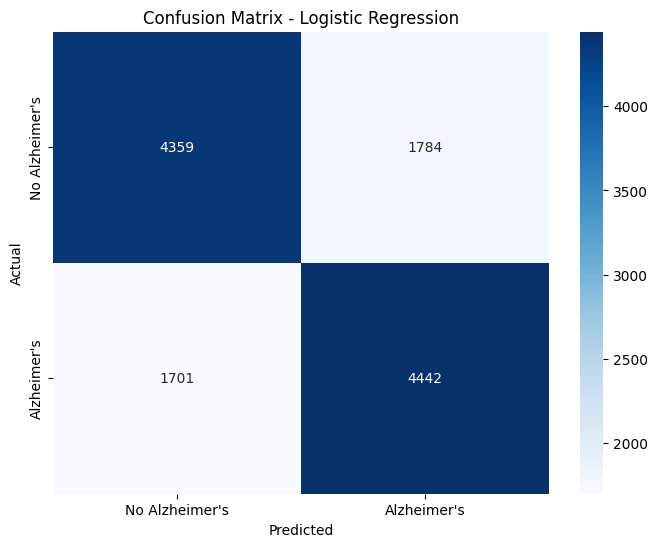

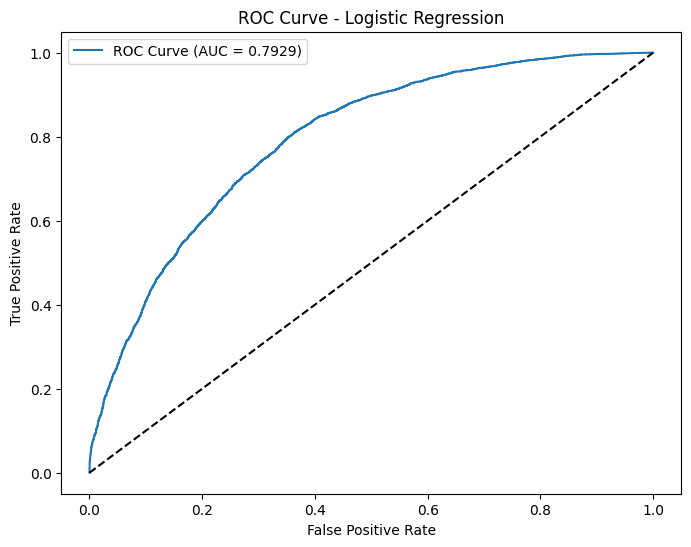


Evaluating Random Forest...

Random Forest Results:
Accuracy: 0.7224
Precision: 0.7094
Recall: 0.7534
F1 Score: 0.7307
ROC AUC: 0.7921

Random Forest Results:
Accuracy: 0.7224
Precision: 0.7094
Recall: 0.7534
F1 Score: 0.7307
ROC AUC: 0.7921


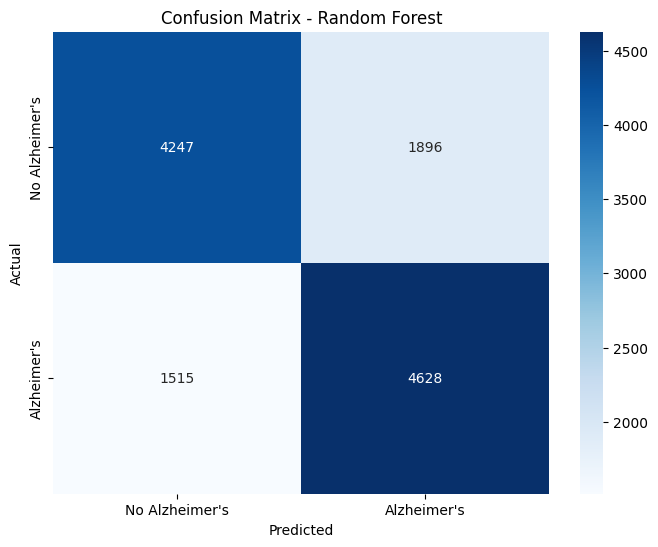

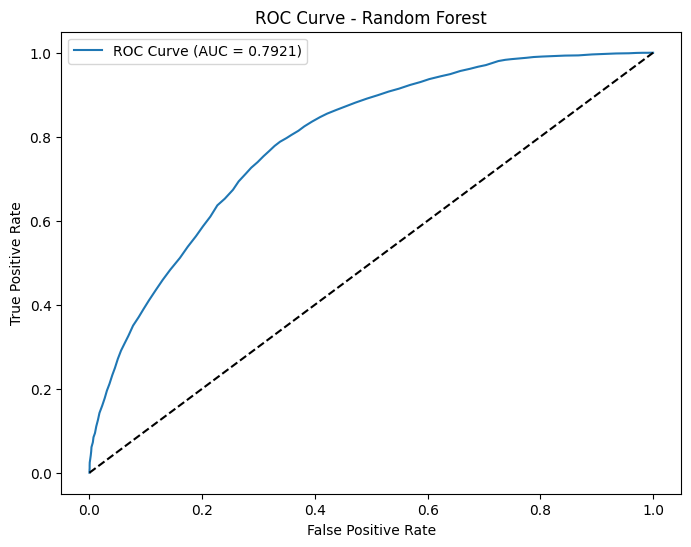


Evaluating Gradient Boosting...

Gradient Boosting Results:
Accuracy: 0.7307
Precision: 0.7140
Recall: 0.7697
F1 Score: 0.7408
ROC AUC: 0.8042

Gradient Boosting Results:
Accuracy: 0.7307
Precision: 0.7140
Recall: 0.7697
F1 Score: 0.7408
ROC AUC: 0.8042


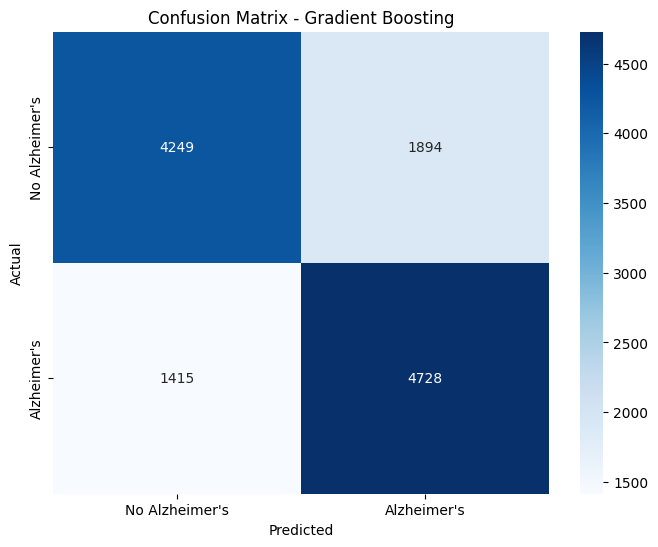

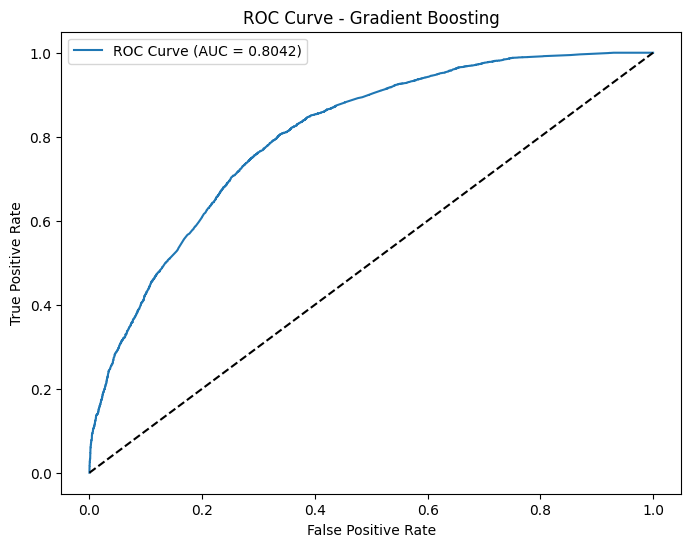


Evaluating XGBoost...

XGBoost Results:
Accuracy: 0.7124
Precision: 0.6996
Recall: 0.7443
F1 Score: 0.7212
ROC AUC: 0.7881

XGBoost Results:
Accuracy: 0.7124
Precision: 0.6996
Recall: 0.7443
F1 Score: 0.7212
ROC AUC: 0.7881


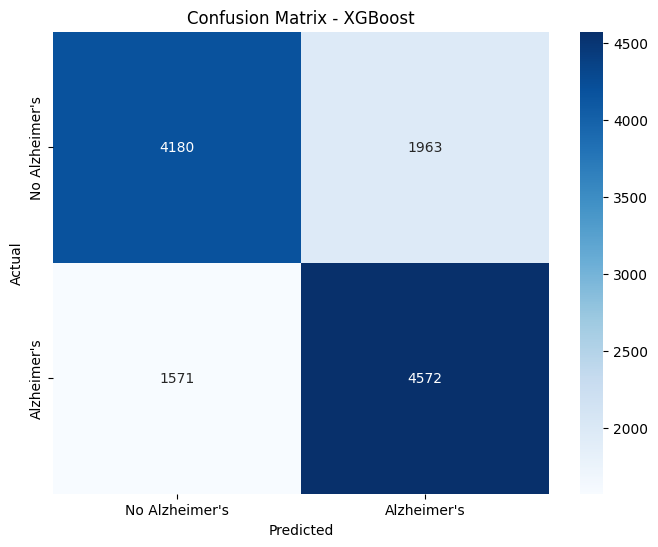

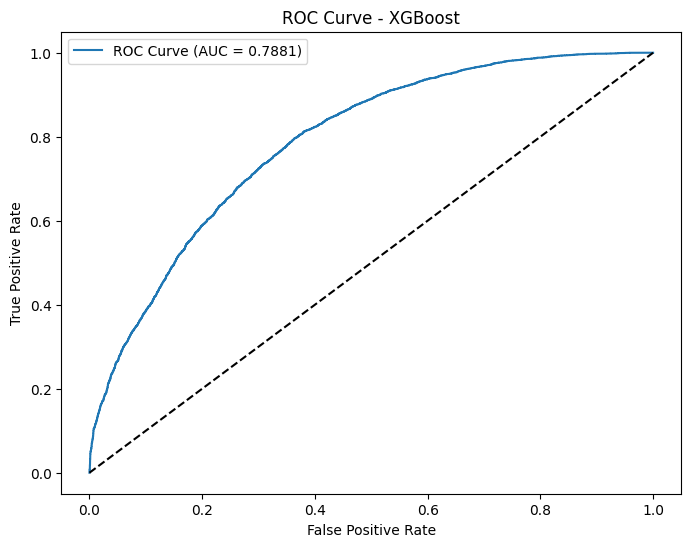

In [31]:
# Evaluate all models
results = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    pipeline, accuracy, roc_auc = evaluate_model(model_name, model, X_train, X_test, y_train, y_test)
    results[model_name] = {'pipeline': pipeline, 'accuracy': accuracy, 'roc_auc': roc_auc}

In [34]:
import pickle

with open('gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(results["Gradient Boosting"]["pipeline"], f)

print("Gradient Boosting model saved as 'gradient_boosting_model.pkl'")
model = results["Gradient Boosting"]["pipeline"]

Gradient Boosting model saved as 'gradient_boosting_model.pkl'


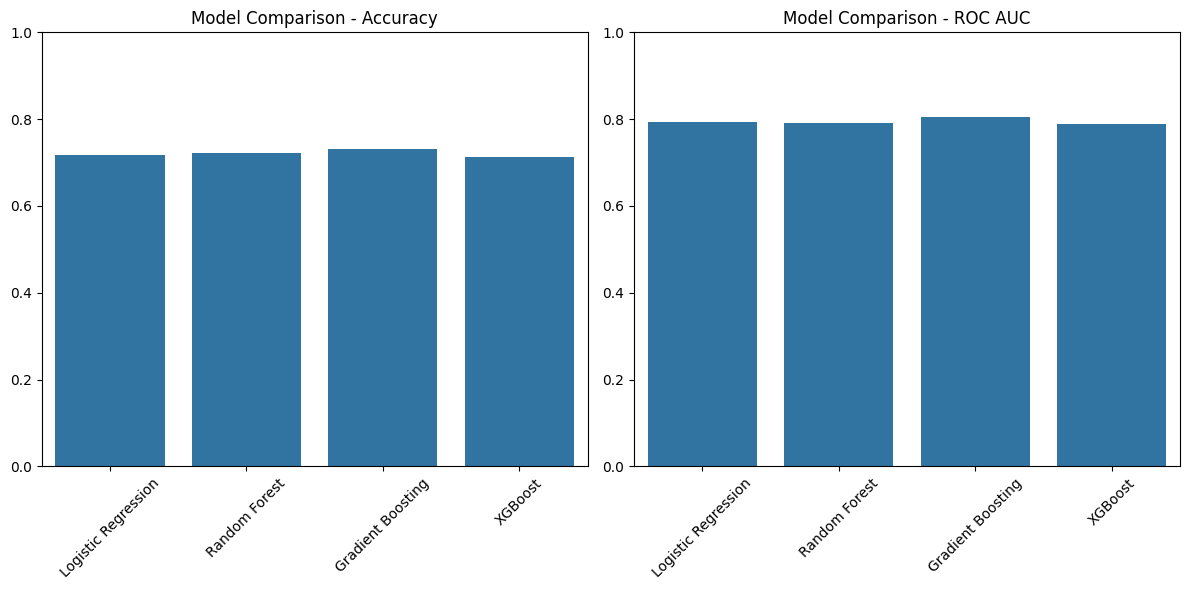

In [118]:
# Compare model performances
accuracies = [results[model]['accuracy'] for model in models.keys()]
roc_aucs = [results[model]['roc_auc'] for model in models.keys()]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=list(models.keys()), y=accuracies)
plt.title('Model Comparison - Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
sns.barplot(x=list(models.keys()), y=roc_aucs)
plt.title('Model Comparison - ROC AUC')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## 10. Model Deployment Example


In [35]:
# Example of how to use the model for prediction
def predict_alzheimers_risk(model, sample_data):
    # Make prediction
    prediction_proba = model.predict_proba(sample_data)[0, 1]
    prediction = model.predict(sample_data)[0]
    
    # Print results
    print(f"Alzheimer's Risk Probability: {prediction_proba:.9f}")
    print(f"Prediction: {'Positive' if prediction == 1 else 'Negative'}")
    
    return prediction, prediction_proba

# Example: Create a sample patient data
# You would replace this with actual patient data
sample_patient = X_test.iloc[0:1]  # Just using the first test sample as an example

# Make prediction
print("Sample Patient Prediction:")
predict_alzheimers_risk(model, sample_patient)
X_test.iloc[0:1]

Sample Patient Prediction:
Alzheimer's Risk Probability: 0.633458943
Prediction: Positive


,Country,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,...,Sleep Quality,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living
46321,Spain,83,Female,14,18.9,Low,Former,Never,No,No,...,Average,Average,Low,Unemployed,Widowed,No,Low,Low,Medium,Urban


In [37]:
def get_user_input():
    # Define the input fields based on the original dataset columns
    input_data = {
        "Country": "India",
        "Age": 23,
        "Gender": "Male",
        "Education Level": 15,
        "BMI": 25,
        "Physical Activity Level": "Medium",
        "Smoking Status": "Former",
        "Alcohol Consumption": "Never",
        "Diabetes": "Yes",
        "Hypertension": "No",
        "Cholesterol Level": "Normal",
        "Family History of Alzheimer’s": "No",
        "Cognitive Test Score": 90,
        "Depression Level": "Low",
        "Sleep Quality": "Good",
        "Air Pollution Exposure": "Low",
        "Employment Status": "Unemployed",
        "Marital Status": "Single",
        "Genetic Risk Factor (APOE-ε4 allele)": "Yes",
        "Social Engagement Level": "High",
        "Income Level": "Low",
        "Stress Levels": "Low",
        "Urban vs Rural Living": "Urban",
        "Dietary Habits": "Healthy",
    }
    
    # Convert the input into a DataFrame
    user_df = pd.DataFrame([input_data])
    
    print("Input data before preprocessing:")
    
    return user_df

# Get user input
print("Creating prediction for provided patient data...")
user_input = get_user_input()

# Make prediction using the trained model
print("\nPrediction Results:")
prediction, probability = predict_alzheimers_risk(model, user_input)


Creating prediction for provided patient data...
Input data before preprocessing:

Prediction Results:
Alzheimer's Risk Probability: 0.455017668
Prediction: Negative
